# Chapter 11

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict

## Baird's counterexample

In [83]:
class Baird:
    """
    env will be an interface with the following methods:
    start: return a starting state
    act: takes in an action and return next_state, reward, is_end
    it should also have a class variable for actions allowed
    """
    actions = ['s', 'd']
    
    def start(self):
        self.state = np.random.randint(0, 7)
        return self.state
    
    def act(self, action):
        if np.random.uniform() < 0.01:
            return None, 0, True
        if action == 's':
            self.state = 6
            return self.state, 0, False
        else:
            i = np.random.randint(0, 6)
            if i < self.state:
                self.state = i
            else:
                self.state = i + 1
            return self.state, 0, False

In [84]:
baird = Baird()

In [85]:
class Policy:
    def getAction(self, state):
        pass
    
    def getProb(state, action):
        pass
    
class BehaviorPolicy(Policy):
    def __call__(self, state):
        return np.random.choice(['d', 'd', 'd', 'd', 'd', 'd', 's'])
    def getProb(self, state, action):
        if action == 'd':
            return 6/7
        else:
            return 1/7

class TargetPolicy(Policy):
    def __call__(self, state):
        return 's'
    def getProb(self, state, action):
        return 1 if action =='s' else 0

In [101]:
def baird_state_action_fn(state):
    features = np.zeros(8)
    features[state] = 2 if state < 6 else 1
    features[7] = 1 if state < 6 else 2
    return features

In [105]:
class OffPolicySGTD0:
    # off policy semi-gradient TD(0)
    
    def __init__(self, env, alpha, gamma, feature_length, state_fn, behaviorPolicy, targetPolicy, init_theta=None):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.state_fn = state_fn
        self.mu = behaviorPolicy
        self.pi = targetPolicy
        if init_theta is not None:
            self.theta = init_theta
        else:
            self.theta = np.zeros(feature_length)
        self.episode = 0
        self.all_theta = [np.copy(self.theta)]
        
    def evaluate(self, episodes):
        while self.episode < episodes:
            state = self.env.start()
            is_end = False
            while not is_end:
                action = self.mu(state)
                next_state, reward, is_end = self.env.act(action)
                features = self.state_fn(state)
                next_value = np.dot(self.state_fn(next_state), self.theta) if not is_end else 0
                td_error = reward + self.gamma * next_value - np.dot(features, self.theta)
                rho = self.pi.getProb(state, action)/self.mu.getProb(state, action)
                self.theta += self.alpha * rho * td_error * features # assume linear fn approx
                state = next_state
            self.all_theta.append(np.copy(self.theta))
            self.episode += 1

In [109]:
agent = OffPolicySGTD0(baird, 0.001, 1, 8, baird_state_action_fn, BehaviorPolicy(), TargetPolicy(), np.array([1,1,1,1,1,1,10,1], dtype='float64'))

In [110]:
agent.evaluate(100)

Text(0.5,1,'Figure 11.2')

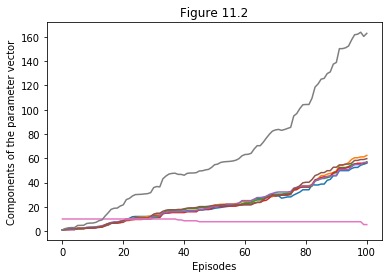

In [112]:
thetas = np.array(agent.all_theta)
for i in range(8):
    plt.plot(range(101), thetas[:, i])

plt.ylabel("Components of the parameter vector")
plt.xlabel("Episodes")
plt.title("Figure 11.2")